In [1]:
#Python
import os

# Setting path to project root
os.chdir(os.path.dirname(os.path.abspath("../../DICE_PRIME_PY/app.py")))

In [5]:
# Charts / Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rttm.batch_generation.RTTM_run as RTTM_run

In [6]:
df = pd.read_json("./rttm/dataset/test_leak.json")

In [7]:
#TODO: Move this to own category

def convert_column_to_df(df, column):
    # define a function to convert a collection of arrays into a DataFrame
    def collection_to_dataframe(collection):
        # create a 2D numpy array from the collection
        arr = np.array(collection)
        # transpose the array to put each element in a separate row
        arr = arr.T
        # create a DataFrame from the array
        return pd.DataFrame(arr)

    # apply the function to each column
    df_col = df[column].apply(collection_to_dataframe)

    # concatenate the resulting DataFrames along axis 2
    df_col = pd.concat(df_col.values.tolist(), axis=1)

    # set the column names of the new DataFrames
    df_col.columns = [f'{i}' for i in range(df_col.shape[1])]
    
    return df_col

In [8]:
class pipeline_data:
    def __init__(self, pressure, velocity, t_step, sim_time, x, length, is_gas, input_leak_percentage, input_leak_position, input_leak_zone, is_leak):
        self.pressure = pressure
        self.velocity = velocity
        self.t_step = t_step
        self.sim_time = sim_time
        self.x = x
        self.length = length
        self.is_gas = is_gas
        self.input_leak_percentage = input_leak_percentage
        self.input_leak_position = input_leak_position
        self.input_leak_zone = input_leak_zone
        self.is_leak = is_leak
        
    def get_pressure(self):
        return self.pressure
    
    def get_velocity(self):
        return self.velocity
    
    def get_t_step(self):
        return self.t_step
    
    def get_sim_time(self):
        return self.sim_time
    
    def get_x(self):
        return self.x
    
    def get_length(self):
        return self.length
    
    def get_is_gas(self):
        return self.is_gas
    
    def get_input_leak_percentage(self):
        return self.input_leak_percentage
    
    def get_input_leak_position(self):
        return self.input_leak_position
    
    def get_input_leak_zone(self):
        return self.input_leak_zone
    
    def get_is_leak(self):
        return self.is_leak


In [9]:
#TODO: Confirm velocity units
pressure = convert_column_to_df(df, 'Pressure')/10**6 # x axis → distance, y axis → time]
velocity = convert_column_to_df(df, 'Velocity') # x axis → distance, y axis → time

t_step = np.array(df['t_step'][0])
sim_time = np.array(df['Sim_time'])[0] #single Value, s

x = np.array(df['x'][0])
length = df['Length'][0] #single Value, meters

# Metadata
is_gas = df['is_gas'][0]
input_leak_percentage = df['input_leak_percentage'][0]
input_leak_position = df['input_leak_position'][0]
input_leak_zone = df['input_leak_zone'][0]
is_leak = df['is_leak'][0]

# Data obtained from the pipeline (with a leak)
SCADA_Data = pipeline_data(pressure, velocity, t_step, sim_time, x, length, is_gas, input_leak_percentage, input_leak_position, input_leak_zone, is_leak)

In [29]:
is_leak = 0
df_no_leak = RTTM_run.single_simulation(is_gas, input_leak_percentage, input_leak_position, input_leak_zone, is_leak)

226.30529236793518 Sec


In [30]:
pressure = convert_column_to_df(df_no_leak, 'Pressure')/10**6 # x axis → distance, y axis → time
velocity = convert_column_to_df(df_no_leak, 'Velocity') # x axis → distance, y axis → time

t_step = np.array(df_no_leak['t_step'][0])
sim_time = np.array(df_no_leak['Sim_time'])

x = np.array(df_no_leak['x'][0])
length = np.array(df_no_leak['Length'])

# Metadata
is_gas = df_no_leak['is_gas'][0]
input_leak_percentage = df_no_leak['input_leak_percentage'][0]
input_leak_position = df_no_leak['input_leak_position'][0]
input_leak_zone = df_no_leak['input_leak_zone'][0]
is_leak = df_no_leak['is_leak'][0]

# Data generated by RTTM simulation (with no leak)
RTTM_Data = pipeline_data(pressure, velocity, t_step, sim_time, x, length, is_gas, input_leak_percentage, input_leak_position, input_leak_zone, is_leak)

In [31]:
## Apply the Gradient Intersection Method
v_no_leak_inlet = RTTM_Data.get_velocity().iloc[1, -1]
v_no_leak_outlet = RTTM_Data.get_velocity().iloc[-1, -1]

v_leak_inlet = SCADA_Data.get_velocity().iloc[1, -1] # Velocity at the inlet of the leak, at the last time step
v_leak_outlet = SCADA_Data.get_velocity().iloc[-1, -1]

x0 = (v_no_leak_inlet**2 - v_leak_outlet**2)/(v_leak_inlet**2-v_leak_outlet**2)
leak_loc_rel = x0 # Relative leak position [%]

In [32]:
## Format output
pipeline_length = SCADA_Data.get_length()
leak_loc_abs = leak_loc_rel*pipeline_length # Absolute leak position [m]

print("Leak position [%]: ", round(leak_loc_rel,2))
print("Leak position [km]: ", round(leak_loc_abs/10**3,4))

real_leak_position = SCADA_Data.get_input_leak_position()
error = abs(real_leak_position - leak_loc_rel)/real_leak_position

print("Error [%]: ", round(error*100,2))

Leak position [%]:  0.47
Leak position [km]:  14.9946
Error [%]:  5.93


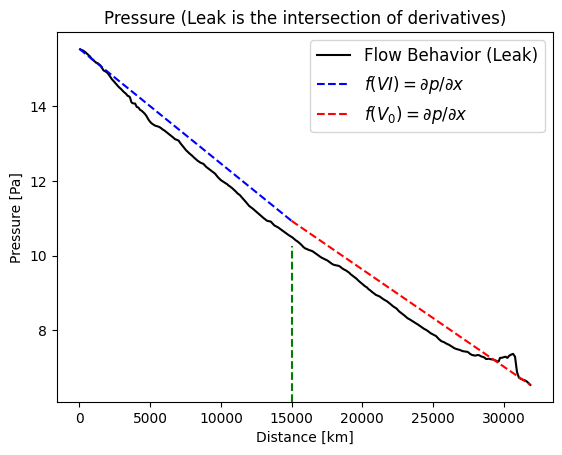

In [33]:
# Visualization
x = SCADA_Data.get_x()
pressure = SCADA_Data.get_pressure()

fig, ax = plt.subplots()
ax.plot(x, pressure.iloc[1:, -1], 'k')
ax.set_title('Pressure (Leak is the intersection of derivatives)')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Pressure [Pa]')

# First Derivative
y0 = pressure.iloc[0, -1]
y1 = pressure.iloc[round(leak_loc_rel*pressure.shape[0]), -1]
x0 = 0
x1 = leak_loc_abs

# Second Derivative
y2 = y1
y3 = pressure.iloc[-1, -1]
x2 = leak_loc_abs
x3 = x[-1]

ax.plot([x0, x1], [y0, y1], 'b--', label='$f( VI ) = \partial p/\partial x$')
ax.plot([x2, x3], [y2, y3], 'r--', label='$f( V_0 ) = \partial p/\partial x$')
ax.legend(['Flow Behavior (Leak)', '$f( VI ) = \partial p/\partial x$', '$f( V_0 ) = \partial p/\partial x$'], fontsize=12)

# Find the x-coordinate of the intersection point
x_int = x1 + (y2-y1)*(x3-x2)/(y3-y2)

# Plot a vertical line at the intersection point
#plt.axvline(x_int, color='g', linestyle='--')

# Plot a vertical line at the intersection point
line_height = 0.1*(pressure.iloc[:,-1].max() - pressure.iloc[:,-1].min())
plt.axvline(x_int, ymin=0, ymax=pressure.iloc[:,-1].min()/pressure.iloc[:,-1].max(), color='g', linestyle='--')
